In [16]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics

In [17]:
# Function to grab data from yfinance
def get_stock(symbols, start_date_list, end_date_list = []):
    """
    Pulls financial data between start and end dates for specify stock.

    Params:
        symbols         : list of stock symbols to create csv files.
        start_date_list : start date in list form (i.e. [<year>, <month>, <day>]).
        end_date_list   : end date in list form (i.e. [<year>, <month>, <day>]).  It does not include the end dates.
        interval        : sample rate of data
        
    Returns:
        Stock data between a specific interval.
    """

    start = dt.date(start_date_list[0], start_date_list[1], start_date_list[2])
    
    if end_date_list == []:
        end = dt.date.today()
    else:
        end = dt.date(end_date_list[0], end_date_list[1], end_date_list[2])

    formatted_start_date = start.strftime("%Y%m%d")
    formatted_end_date = end.strftime("%Y%m%d")

    data = yf.download(symbols, start = start, end = end)

    col_name_change = {"Close": "close", "High": "high", "Low": "low", "Volume": "volume", "Open": "open", "Adj Close": "adj_close"}
    
    data.rename(columns = col_name_change, inplace = True)

    return data

In [18]:
# Selecting Stock via Stock Symbol
symbols = "BAC"

start_date_list = [2017, 1, 1]

# Run the stock grabber function
data = get_stock(symbols, start_date_list)
print(data.head())
print(data.tail())

[*********************100%***********************]  1 of 1 completed
                 open       high        low      close  adj_close    volume
Date                                                                       
2017-01-03  22.600000  22.680000  22.200001  22.530001  20.247801  99298100
2017-01-04  22.719999  22.959999  22.600000  22.950001  20.625254  76875100
2017-01-05  22.820000  22.930000  22.350000  22.680000  20.382607  86826400
2017-01-06  22.780001  22.850000  22.559999  22.680000  20.382607  66281500
2017-01-09  22.510000  22.709999  22.400000  22.549999  20.265770  75901500
                 open       high        low      close  adj_close    volume
Date                                                                       
2022-05-16  35.000000  35.169998  34.410000  34.810001  34.810001  39076500
2022-05-17  35.619999  36.220001  35.430000  35.990002  35.990002  42635600
2022-05-18  35.619999  35.689999  34.599998  34.880001  34.880001  47396900
2022-05-19  34.2900

<AxesSubplot:xlabel='Date'>

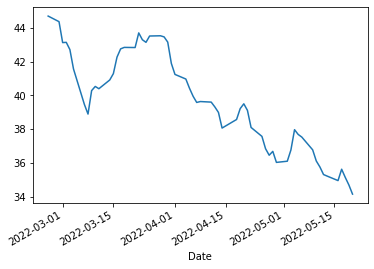

In [22]:
# Plot stock based on closing price from the last 60 days
stock_plot = data.iloc[-60:]
stock_plot['close'].plot()

In [20]:
# List of symbols for technical indicators to grab from finta library
finta_indicators = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

<AxesSubplot:xlabel='Date'>

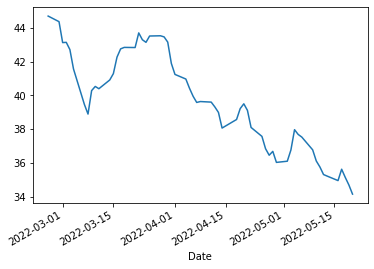

In [21]:
# Clean stock data and perform feature selection to create new technical indicator features that model can learn from
def exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are smoother
    """
    
    return data.ewm(alpha=alpha).mean()

<AxesSubplot:xlabel='Date'>

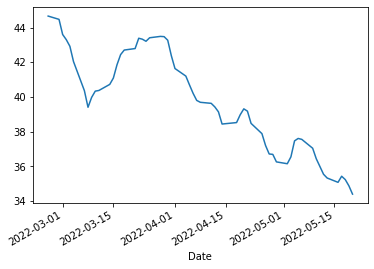

In [23]:
# Plot the smoothed out stock plot based on the last 60 days
data = exponential_smooth(data, 0.65)

stock_plot_smooth = data.iloc[-60:]
stock_plot_smooth['close'].plot()

In [24]:
# Function that uses the finta API to calculate indicators used for features
def get_indicator_data(data):
    """
    Function that uses the finta API to calculate indicators used as the features
    """

    for indicator in finta_indicators:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    data = data.drop(columns = ["open", "high", "low", "volume", "adj_close"])
    
    return data

data = get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [25]:
# Function creates column of predicted values
def produce_prediction(data, window):
    """
    Function that produces predicted values.  Looks ahead a specific amt and see if the prices increase (1) or decrease (0)
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

In [26]:
data = produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2022-04-25,24.839424,-1.154122,-1.077559,16.443683,4.398195e+07,1.107631,-1.806159,28.713262,-5.780413,5.890825e+09,-111.306967,-0.005264,1.215036,0.773822,0.881793,0.914488,0.933509,0.968339,1.037182,0.0
2022-04-26,21.900010,-1.229373,-1.107922,11.680245,2.948552e+07,1.128855,-2.428806,28.990880,-6.524991,5.838822e+09,-132.918593,-0.005561,1.209759,0.771440,0.868194,0.902200,0.921816,0.958745,0.968785,0.0
2022-04-27,20.064878,-1.313392,-1.149016,7.079730,7.566827e+06,1.144614,-2.712609,29.466301,-7.502338,5.792456e+09,-153.216803,-0.005639,1.201052,0.785180,0.859180,0.894785,0.915193,0.954698,0.883830,0.0
2022-04-28,19.981484,-1.366059,-1.192425,10.334777,3.538936e+06,1.142785,-2.450522,30.088564,-7.419875,5.749654e+09,-153.745038,-0.005439,1.195596,0.806005,0.861036,0.898553,0.919864,0.961462,0.841744,0.0
2022-04-29,18.405714,-1.426318,-1.239203,7.263125,-1.725250e+07,1.164018,-2.181595,30.436626,-8.035012,5.705351e+09,-152.425633,-0.005667,1.187202,0.794556,0.853366,0.892490,0.914552,0.958077,0.890343,0.0


In [27]:
def train_random_forest(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """
    
    # Create a new random forest classifier
    rf = RandomForestClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best

In [28]:
def train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best

In [80]:
def _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test):
    
    # Create a dictionary of our models
    estimators=[('knn', knn_model), ('rf', rf_model)]
    
    # Create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='hard')
    
    #fit model to training data
    ensemble.fit(X_train, y_train)
    
    #test our model on the test data
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble

In [ ]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        rf_model = _train_random_forest(X_train, y_train, X_test, y_test)
        knn_model = _train_KNN(X_train, y_train, X_test, y_test)
        ensemble_model = _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test)
        
        rf_prediction = rf_model.predict(X_test)
        knn_prediction = knn_model.predict(X_test)
        ensemble_prediction = ensemble_model.predict(X_test)
        
        print('rf prediction is ', rf_prediction)
        print('knn prediction is ', knn_prediction)
        print('ensemble prediction is ', ensemble_prediction)
        print('truth values are ', y_test.values)
        
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
        print(rf_accuracy, knn_accuracy, ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
        
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('Ensemble Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))

In [81]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        rf_model = _train_random_forest(X_train, y_train, X_test, y_test)
        knn_model = _train_KNN(X_train, y_train, X_test, y_test)
        ensemble_model = _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test)
        
        rf_prediction = rf_model.predict(X_test)
        knn_prediction = knn_model.predict(X_test)
        ensemble_prediction = ensemble_model.predict(X_test)
        
        print('rf prediction is ', rf_prediction)
        print('knn prediction is ', knn_prediction)
        print('ensemble prediction is ', ensemble_prediction)
        print('truth values are ', y_test.values)
        
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
        print(rf_accuracy, knn_accuracy, ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
        
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('Ensemble Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))

In [82]:
cross_Validation(data)

10 50
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.33      0.50        12

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[0 0]
 [8 4]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.33      0.50        12

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[0 0]
 [8 4]]
0.25
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40        12

    accuracy                           0.25        12
   macro avg       0.50      0.12      0.20        12
weighted avg       1.00      0.25      0.40        12

[[0 0]
 [9 3]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf prediction is  [1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
knn prediction is  [1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
ensemble prediction is  [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.3333333333333333 0.3333333333333333 0.25
20 60
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
0.5 0.5 0.5
30 70
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.10      0.18        10
         1.0       0.18      1.00      0.31         2

    accuracy                           0.25        12
   macro avg       0.59      0.55      0.24        12
weighted avg       0.86      0.25      0.20        12

[[1 9]
 [0 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33        10
         1.0       0.20      1.00      0.33         2

    accuracy                           0.33        12
   macro avg       0.60      0.60      0.33        12
weighted avg       0.87      0.33      0.33        12

[[2 8]
 [0 2]]
0.3333333333333333
              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33        10
         1.0       0.20      1.00      0.33         2

    accuracy                           0.33        12
   macro avg       0.60      0.60      0.33        12
weighted avg       0.87      0.33      0.33        12

[[2 8]
 [0 2]]
rf prediction is  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
0.25 0.3333333333333333 0.3333333333333333
40 8

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.67        12
   macro avg       0.50      0.33      0.40        12
weighted avg       1.00      0.67      0.80        12

[[8 4]
 [0 0]]
0.6666666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.67        12
   macro avg       0.50      0.33      0.40        12
weighted avg       1.00      0.67      0.80        12

[[8 4]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf prediction is  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.5833333333333334 0.6666666666666666 0.6666666666666666
50 90
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77         5
         1.0       1.00      0.57      0.73         7

    accuracy                           0.75        12
   macro avg       0.81      0.79      0.75        12
weighted avg       0.84      0.75      0.74        12

[[5 0]
 [3 4]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
rf prediction is 

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
0.75 0.4166666666666667 0.4166666666666667
60 100
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         6
         1.0       1.00      0.67      0.80         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12

[[6 0]
 [2 4]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83         6
         1.0       0.83      0.83      0.83         6

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12

[[5 1]
 [1 5]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92         6
         1.0       1.00      0.83      0.91         6

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12

[[6 0]
 [1 5]]
rf prediction is  [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
ensemble prediction is  [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
0.8333333333333334 0.8333333333333334 0.9166666

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]
0.25
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.3333333333333333 0.25 0.25
80 120
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.58      0.74        12

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[0 0]
 [5 7]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 11}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.58      0.74        12

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[0 0]
 [5 7]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf prediction is  [1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.5833333333333334 0.8333333333333334 0.5833333333333334
90 130
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.08      0.15        12

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12

[[ 0  0]
 [11  1]]
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.0 0.08333333333333333 0.0
100 140
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

0.8333333333333334 0.8333333333333334 0.8333333333333334
110 150
{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 5}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0 1.0 1.0
120 160


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         3
         1.0       0.90      1.00      0.95         9

    accuracy                           0.92        12
   macro avg       0.95      0.83      0.87        12
weighted avg       0.92      0.92      0.91        12

[[2 1]
 [0 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         3
         1.0       0.90      1.00      0.95         9

    accuracy                           0.92        12
   macro avg       0.95      0.83      0.87        12
weighted avg       0.92      0.92      0.91        12

[[2 1]
 [0 9]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
0.9166666666666666 0.75 0.9166666666666666
130 

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93         8
         1.0       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12

[[7 1]
 [0 4]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[0 8]
 [0 4]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93         8
         1.0       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12

[[7 1]
 [0 4]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
0.9166666666666666 0.3333333333333333 0.9166666

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 13}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.75      0.86        12

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[0 0]
 [3 9]]
0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.75      0.86        12

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[0 0]
 [3 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0 0.75 0.75
150 190
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 7}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

rf prediction is  [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.5 0.0 0.0
160 200
{'n_estimators': 160}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.42      0.59        12

    accuracy                           0.42        12
   macro avg       0.50      0.21      0.29        12
weighted avg       1.00      0.42      0.59        12

[[0 0]
 [7 5]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 11}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.42      0.59        12

    accuracy                           0.42        12
   macro avg       0.50      0.21      0.29        12
weighted avg       1.00      0.42      0.59        12

[[0 0]
 [7 5]]
rf prediction is  [1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.4166666666666667 1.0 0.4166666666666667
170 210


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0 1.0 1.0
180 220
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00  

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

[[0 6]
 [0 6]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
0.5 0.5 0.5
190 230


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         2
         1.0       1.00      0.90      0.95        10

    accuracy                           0.92        12
   macro avg       0.83      0.95      0.87        12
weighted avg       0.94      0.92      0.92        12

[[2 0]
 [1 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 9}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         2
         1.0       1.00      0.90      0.95        10

    accuracy                           0.92        12
   macro avg       0.83      0.95      0.87        12
weighted avg       0.94      0.92      0.92        12

[[2 0]
 [1 9]]
rf prediction is  [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.9166666666666666 0.8333333333333334 0.916

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 6}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.9166666666666666 1.0 1.0
210 250
{'n_estimators': 180}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 11}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[ 0  1]
 [ 0 11]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
0.9166666666666666 0.9166666666666666 

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.08333333333333333 0.08333333333333333 0.08333333333333333
230 270
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[4 8]
 [0 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.29        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.17        12
   macro avg       0.50      0.08      0.14        12
weighted avg       1.00      0.17      0.29        12

[[ 2 10]
 [ 0  0]]
0.3333333333333333


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[4 8]
 [0 0]]
rf prediction is  [0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.]
ensemble prediction is  [1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.3333333333333333 0.16666666666666666 0.3333333333333333
240 280
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 9}
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

0.8333333333333334 0.8333333333333334 0.8333333333333334
250 290
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[11  0]
 [ 1  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        11
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[11  0]
 [ 0  1]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[11  0]
 [ 1  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
0.9166666666666666 1.0 0.9166666666666666
260 300
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.10      1.00      0.18         1
         1.0       1.00      0.18      0.31        11

    accuracy                           0.25        12
   macro avg       0.55      0.59      0.24        12
weighted avg       0.92      0.25      0.30        12

[[1 0]
 [9 2]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         1
         1.0       1.00      0.82      0.90        11

    accuracy                           0.83        12
   macro avg       0.67      0.91      0.70        12
weighted avg       0.94      0.83      0.87        12

[[1 0]
 [2 9]]
0.25
              precision    recall  f1-score   support

         0.0       0.10      1.00      0.18         1
         1.0       1.00      0.18      0.31        11

    accuracy                           0.25        12
   macro avg       0.55      0.59      0.24        12
weighted avg       0.92      0.25      0.30        12

[[1 0]
 [9 2]]
rf prediction is  [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.]
ensemble prediction is  [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.25 0.8333333333333334 0.25
270 310
{'n_estimators': 110}
  

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75         3
         1.0       1.00      0.78      0.88         9

    accuracy                           0.83        12
   macro avg       0.80      0.89      0.81        12
weighted avg       0.90      0.83      0.84        12

[[3 0]
 [2 7]]
0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.43      1.00      0.60         3
         1.0       1.00      0.56      0.71         9

    accuracy                           0.67        12
   macro avg       0.71      0.78      0.66        12
weighted avg       0.86      0.67      0.69        12

[[3 0]
 [4 5]]
rf prediction is  [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
ensemble prediction is  [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
0.5833333333333334 0.8333333333333334 0.6666666

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       1.00      0.10      0.18        10
         1.0       0.18      1.00      0.31         2

    accuracy                           0.25        12
   macro avg       0.59      0.55      0.24        12
weighted avg       0.86      0.25      0.20        12

[[1 9]
 [0 2]]
0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.88      0.70      0.78        10
         1.0       0.25      0.50      0.33         2

    accuracy                           0.67        12
   macro avg       0.56      0.60      0.56        12
weighted avg       0.77      0.67      0.70        12

[[7 3]
 [1 1]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
0.8333333333333334 0.25 0.6666666666666666
290 

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89         5
         1.0       0.88      1.00      0.93         7

    accuracy                           0.92        12
   macro avg       0.94      0.90      0.91        12
weighted avg       0.93      0.92      0.91        12

[[4 1]
 [0 7]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89         5
         1.0       0.88      1.00      0.93         7

    accuracy                           0.92        12
   macro avg       0.94      0.90      0.91        12
weighted avg       0.93      0.92      0.91        12

[[4 1]
 [0 7]]
rf prediction is  [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
0.75 0.9166666666666666 0.9166666666666666
300 

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 3}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.92      0.96        12

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[ 0  0]
 [ 1 11]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0 1.0 0.9166666666666666
310 350
{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 12}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.17      0.29        12

    accuracy                           0.17        12
   macro avg       0.50      0.08      0.14        12
weighted avg       1.00      0.17      0.29        12

[[ 0  0]
 [10  2]]
0.0


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.0 0.16666666666666666 0.0
320 360
{'n_estimators': 160}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 7}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.83      1.00      0.91        10

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[ 0  2]
 [ 0 10]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
0.8333333333333334 0.8333333333333334 0

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

 0.0 0.0
340 380
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.29        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.17        12
   macro avg       0.50      0.08      0.14        12
weighted avg       1.00      0.17      0.29        12

[[ 2 10]
 [ 0  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.16666666666666666 1.0 1.0
350 390
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84         9
         1.0       

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]
0.75


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
0.75 0.75 0.75
360 400
{'n_estimators': 180}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.0 0.0 0.0
370 410


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/op

{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[3 0]
 [0 9]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[0 3]
 [0 9]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[3 0]
 [0 9]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
1.0 0.75 1.0
380 420
{'n_estimators': 110}
              preci

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.83      0.56      0.67         9
         1.0       0.33      0.67      0.44         3

    accuracy                           0.58        12
   macro avg       0.58      0.61      0.56        12
weighted avg       0.71      0.58      0.61        12

[[5 4]
 [1 2]]
0.75
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
0.75 0.5833333333333334 0.75
390 430
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmb

{'n_neighbors': 11}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

[[0 4]
 [0 8]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666 0.6666666666666666 0.6666666666666666
400 440
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[10  2]
 [ 0  0]]


/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.8333333333333334 1.0 1.0
410 450
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.12      0.22         8
         1.0       0

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       1.00      0.12      0.22         8
         1.0       0.36      1.00      0.53         4

    accuracy                           0.42        12
   macro avg       0.68      0.56      0.38        12
weighted avg       0.79      0.42      0.33        12

[[1 7]
 [0 4]]
0.4166666666666667
              precision    recall  f1-score   support

         0.0       1.00      0.12      0.22         8
         1.0       0.36      1.00      0.53         4

    accuracy                           0.42        12
   macro avg       0.68      0.56      0.38        12
weighted avg       0.79      0.42      0.33        12

[[1 7]
 [0 4]]
rf prediction is  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
0.4166666666666667 0.4166666666666667 0.4166666

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 14}
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40         4
         1.0       0.73      1.00      0.84         8

    accuracy                           0.75        12
   macro avg       0.86      0.62      0.62        12
weighted avg       0.82      0.75      0.69        12

[[1 3]
 [0 8]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12

[[3 1]
 [0 8]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
0.9166666666666666 0.75 0.9166666666666666
430

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/rmbp2015/opt/anaconda3/lib/pytho

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0 1.0 1.0
440 480
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50        12
         1.0       0.00      0.00  

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       1.00      0.08      0.15        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12

[[ 1 11]
 [ 0  0]]
0.3333333333333333
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[4 8]
 [0 0]]
rf prediction is  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.3333333333333333 0.08333333333333333 0.33

/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rmbp2015/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
